# Variational Message Passing for Estimation

In this demo we showcase a more advanced use of VMP. We wish to estimate the statistics of a two-component Gaussian mixture model.

\begin{align*}
    z_i &\sim \mathcal{B}er(\pi)\\
    y_i &\sim
    \begin{cases}
        \mathcal{N}(m_1, w_1^{-1}) &\text{if } z_i = 1\\
        \mathcal{N}(m_2, w_2^{-1}) &\text{otherwise}
    \end{cases}
\end{align*}

A single section of the factor graph is drawn below

```
           [Ber]
             | (z_i)
             |
-------------|-------> = -> (w2)
             |         |
-------------|----> = -|--> (w1)
             |      |  |
-----> = ----|------|--|--> (m1)
       |     |      |  |
--> = -|-----|------|--|--> (m2)
    |  |     v      |  |
    |  --->|----|<---  |
    |      | GM |      |
    ------>|----|<------ 
             |
             v
           (y_i)
```

In [1]:
# Generate toy dataset
srand(238)
n = 20

y_data = Vector{Float64}(n)
m_1_data = 4.0
w_1_data = 2.0
m_2_data = -4.0
w_2_data = 2.0

z_data = rand(n)
for i = 1:n
    if z_data[i] < 0.5
        y_data[i] = sqrt(1/w_1_data)*randn() + m_1_data
    else
        y_data[i] = sqrt(1/w_2_data)*randn() + m_2_data
    end
end

# Build

The `GaussianMixture` constructor allows for a variable number of arguments. E.g. for a three-component mixture, an `m_3` and `w_3` argument may be appended. Note that in that case, the `Bernoulli` variable will need to change to a `Categorical` as well.

In [2]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV m_1 ~ GaussianMeanVariance(constant(5.0), constant(100.0), id=:m_1)
@RV w_1 ~ Gamma(constant(0.01), constant(0.01), id=:w_1)
@RV m_2 ~ GaussianMeanVariance(constant(-5.0), constant(100.0), id=:m_2)
@RV w_2 ~ Gamma(constant(0.01), constant(0.01), id=:w_2)

z = Vector{Variable}(n)
y = Vector{Variable}(n)
for i = 1:n
    @RV z[i] ~ Bernoulli(constant(0.5), id=:z_*i)
    @RV y[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2, id=:y_*i)
    
    placeholder(y[i], :y, index=i)
end

# Schedule

In [3]:
rf = RecognitionFactorization()

# Specify recognition factorization
q_m_1 = RecognitionFactor(m_1)
q_w_1 = RecognitionFactor(w_1)
q_m_2 = RecognitionFactor(m_2)
q_w_2 = RecognitionFactor(w_2)
q_z = RecognitionFactor(z)
;

In [4]:
# ForneyLab.draw(q_z)

In [5]:
# Generate Julia algorithm code
algo_q_m_1 = variationalAlgorithm(q_m_1, name="M1")
algo_q_w_1 = variationalAlgorithm(q_w_1, name="W1")
algo_q_m_2 = variationalAlgorithm(q_m_2, name="M2")
algo_q_w_2 = variationalAlgorithm(q_w_2, name="W2")
algo_q_z = variationalAlgorithm(q_z, name="Z")

algo_F = freeEnergyAlgorithm()
;

In [6]:
# println(algo_q_z)

# Infer

In [7]:
# Load algorithms
eval(parse(algo_q_m_1))
eval(parse(algo_q_w_1))
eval(parse(algo_q_m_2))
eval(parse(algo_q_w_2))
eval(parse(algo_q_z))
eval(parse(algo_F))
;

In [8]:
data = Dict(:y => y_data)

# Prepare recognition distributions
marginals = Dict(:m_1 => vague(Gaussian),
                 :w_1 => vague(Gamma),
                 :m_2 => vague(Gaussian),
                 :w_2 => vague(Gamma))
for i = 1:n
    marginals[:z_*i] = vague(Bernoulli)
end

# Execute algorithm
n_its = 3*n
F = Vector{Float64}(n_its)
m_1_est = Vector{Float64}(n_its)
w_1_est = Vector{Float64}(n_its)
m_2_est = Vector{Float64}(n_its)
w_2_est = Vector{Float64}(n_its)
for i = 1:n_its
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
    stepZ!(data, marginals)
    
    F[i] = freeEnergy(data, marginals)
    
    # Store estimates for visualization
    m_1_est[i] = mean(marginals[:m_1])
    w_1_est[i] = mean(marginals[:w_1])
    m_2_est[i] = mean(marginals[:m_2])
    w_2_est[i] = mean(marginals[:w_2])
end

# Results

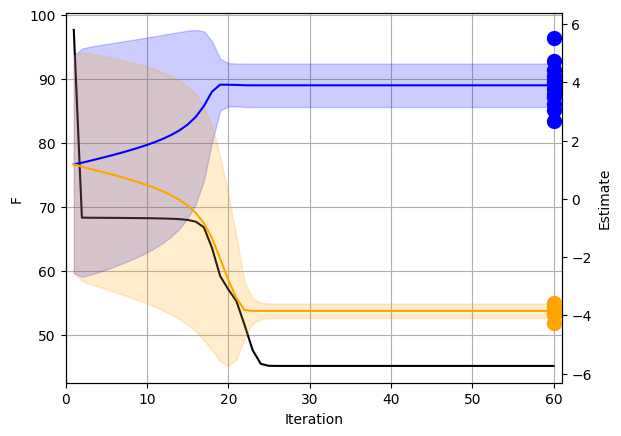

In [9]:
using PyPlot

# Plot free energy to check for convergence
plot(1:n_its, F, color="black")
grid("on")
xlabel("Iteration")
ylabel("F")

# Plot estimated distribution
PyPlot.plt[:twinx]()
plot(1:n_its, m_1_est, color="blue")
fill_between(1:n_its, m_1_est-sqrt.(1.0./w_1_est), m_1_est+sqrt.(1.0./w_1_est), color="blue", alpha=0.2)
plot(1:n_its, m_2_est, color="orange")
fill_between(1:n_its, m_2_est-sqrt.(1.0./w_2_est), m_2_est+sqrt.(1.0./w_2_est), color="orange", alpha=0.2)
ylabel("Estimate")

# Plot samples
scatter(n_its*ones(sum(z_data .< 0.5)), y_data[z_data .< 0.5], color="blue", linewidth=5)
scatter(n_its*ones(sum(z_data .>= 0.5)), y_data[z_data .>= 0.5], color="orange", linewidth=5)

xlim(0.0, n_its+1)
;

In [10]:
# Inspect the results
println("\n----- Estimates after $(n_its) VMP updates -----")
println("m_1 estimate: $(round(mean(marginals[:m_1]),2)), with variance $(round(var(marginals[:m_1]),2))")
println("w_1 estimate: $(round(mean(marginals[:w_1]),2)), with variance $(round(var(marginals[:w_1]),2))")
println("m_2 estimate: $(round(mean(marginals[:m_2]),2)), with variance $(round(var(marginals[:m_2]),2))")
println("w_2 estimate: $(round(mean(marginals[:w_2]),2)), with variance $(round(var(marginals[:w_2]),2))")


----- Estimates after 60 VMP updates -----
m_1 estimate: 3.9, with variance 0.04
w_1 estimate: 1.81, with variance 0.5
m_2 estimate: -3.85, with variance 0.01
w_2 estimate: 16.05, with variance 73.43
